In [26]:
import ismrmrd
import rtoml
import os
from scipy.io import loadmat
from scipy.signal.windows import tukey
from scipy.signal import savgol_filter
import numpy as np
from numpy.fft import ifftshift
import mrdhelper
import pilottone as pt
from pilottone.pt import extract_triggers
import matplotlib.pyplot as plt

from pilottone_ecg_jitter import pt_ecg_jitter
%matplotlib widget

def extract_raw_pt(ksp_measured, f_diff, df, kx, ky, acq: ismrmrd.Acquisition, n_unique_angles, dt):
    
    n_acq = ksp_measured.shape[1]
    # ================================
    # Demodulate any shifts
    # ================================
    phase_mod_rads = pt.calc_fovshift_phase(kx, ky, acq)
    phase_mod_rads = [phase_mod_rads[:,ii%n_unique_angles] for ii in range(n_acq)]
    phase_mod_rads = np.array(phase_mod_rads)[:, :].transpose()[:,:,None]

    # Apply the negative of the phase
    ksp_measured_ = ksp_measured*phase_mod_rads

    # plt.figure()
    # plt.plot(np.abs(pt.signal.to_hybrid_kspace(ksp_measured[:,10,0])))
    # plt.plot(np.abs(pt.signal.to_hybrid_kspace(ksp_measured_[:,10,0])))
    # plt.show()

    fcorrmin = pt.find_freq_qifft(ksp_measured_[:,:,:], df, f_diff, 3e3, 4, (2))

    ksp_window = np.ones(ksp_measured_.shape[0])
    # ksp_window = ksp_window[nc:]
    ksp_measured_ = ksp_measured_*ksp_window[:,None,None]

    time_acq = np.arange(0, ksp_measured_.shape[0])*dt

    ksp_ptsubbed_, pt_sig_fit = pt.est_dtft(time_acq, ksp_measured_, np.array([f_diff])-fcorrmin, ksp_window)

    pt_sig_fit = np.abs(pt_sig_fit)
    # pt_sig = np.squeeze(pt_sig_fit - np.mean(pt_sig_fit, axis=1, keepdims=True))
    pt_sig = np.squeeze(pt_sig_fit)

    # Filter a bandwidth around the pilot tone frequency.
    fbw = 100e3
    freq_axis = ifftshift(np.fft.fftfreq(ksp_ptsubbed_.shape[0], dt))

    ksp_win = tukey(2*ksp_ptsubbed_.shape[0], alpha=0.1)
    ksp_win = ksp_win[(ksp_ptsubbed_.shape[0]):,None,None]
    ksp_ptsubbed_ = ksp_ptsubbed_*ksp_win # kspace filtering to remove spike at the end of the acquisition

    ptmdlflt = np.ones((ksp_ptsubbed_.shape[0]))
    ptmdlflt[(freq_axis < (f_diff+fbw/2)) & (freq_axis > (f_diff-fbw/2))] = 0
    ksp_ptsubbed_ = pt.signal.from_hybrid_kspace(ptmdlflt[:,None,None]*pt.signal.to_hybrid_kspace(ksp_ptsubbed_))
    ksp_ptsubbed = ksp_ptsubbed_*np.conj(phase_mod_rads)
    # plt.figure()
    # plt.plot(freq_axis, np.abs(pt.signal.to_hybrid_kspace(ksp_ptsubbed_[:,10,0])))
    # plt.xlabel('Frequency [Hz]')
    # plt.show()

    # pt_sig_clean2 = pt.signal.angle_dependant_filtering(pt_sig, n_unique_angles)
    pt_sig_clean2 = pt_sig
    return pt_sig_clean2, ksp_ptsubbed


In [ ]:
cfg_ = 'configs/config_vol1133.toml'
# cfg_ = 'configs/config_arr_p3.toml'

with open(cfg_, 'r') as cf:
    cfg = rtoml.load(cf)

In [3]:
# ismrmrd_data_fullpath = '/server/home/btasdelen/MRI_DATA/pilottone/vol1133_20250316/raw/h5/meas_MID00705_FID12633_pulseq2D_fire_spiralga_200mV_24MHz_motion.h5'
ismrmrd_data_fullpath = '/server/home/btasdelen/MRI_DATA/pilottone/vol1133_20250316/raw/h5/meas_MID00700_FID12628_pulseq2D_fire_spiralga_200mV_24MHz.h5'

# ismrmrd_data_fullpath = '/server/home/btasdelen/MRI_DATA/pilottone/vol0986_20241002/raw/h5/meas_MID00198_FID24630_pulseq2D_fire_spiralga_400mV_24MHz.h5'

ismrmrd_data_fullpath_cal = '/server/home/btasdelen/MRI_DATA/pilottone/vol1133_20250316/raw/h5/meas_MID00699_FID12627_pulseq2D_fire_spiralga_200mV_24MHz_calNoGrad.h5'

# ismrmrd_data_fullpath = '/server/home/btasdelen/MRI_DATA/pilottone/vol1181_20250416/raw/h5/meas_MID00228_FID14922_pulseq2D_fire_spiralga_200mV_24MHz_motion.h5'
# ismrmrd_data_fullpath_cal = '/server/home/btasdelen/MRI_DATA/pilottone/vol1181_20250416/raw/h5/meas_MID00225_FID14919_pulseq2D_fire_spiralga_200mV_24MHz_calwGrad.h5'


f_pt = cfg['pilottone']['pt_freq']
remove_os = cfg['saving']['remove_os']

data_dir = os.path.join('/', *(os.path.dirname(ismrmrd_data_fullpath).split('/')[:-2]))
print(f"Data dir: {data_dir}")

raw_file = ismrmrd_data_fullpath.split('/')[-1]
ismrmrd_data_fullpath, ismrmrd_noise_fullpath = mrdhelper.siemens_mrd_finder(data_dir, '', raw_file)

acq_list, wf_list, hdr = mrdhelper.read_mrd(ismrmrd_data_fullpath)
n_acq = len(acq_list)

acq_list_cal, _, _ = mrdhelper.read_mrd(ismrmrd_data_fullpath_cal)
# get the k-space trajectory based on the metadata hash.
traj_name = hdr.userParameters.userParameterString[1].value

# load the .mat file containing the trajectory
traj = loadmat(os.path.join(data_dir, traj_name), squeeze_me=True)

n_unique_angles = int(traj['param']['repetitions'])
pre_discard = int(traj['param']['pre_discard'])

kx = np.vstack((np.zeros((pre_discard, n_unique_angles)), traj['kx'][:,:]))
ky = np.vstack((np.zeros((pre_discard, n_unique_angles)), traj['ky'][:,:]))
dt = float(traj['param']['dt'])

data = np.array([arm.data[:,:] for arm in acq_list])
data = np.transpose(data, axes=(2, 0, 1))

data_cal = np.array([arm.data[:,:] for arm in acq_list_cal])
data_cal = np.transpose(data_cal, axes=(2, 0, 1))


Data dir: /server/home/btasdelen/MRI_DATA/pilottone/vol1133_20250316
Reading /server/home/btasdelen/MRI_DATA/pilottone/vol1133_20250316/raw/h5/meas_MID00700_FID12628_pulseq2D_fire_spiralga_200mV_24MHz.h5...
There are 17280 acquisitions in the file. Reading...


There are 5115 waveforms in the dataset. Reading...
Reading /server/home/btasdelen/MRI_DATA/pilottone/vol1133_20250316/raw/h5/meas_MID00699_FID12627_pulseq2D_fire_spiralga_200mV_24MHz_calNoGrad.h5...
There are 3600 acquisitions in the file. Reading...
There are 1460 waveforms in the dataset. Reading...


In [4]:
n_channels = data.shape[2]
sensing_coils = np.array(cfg['pilottone']['sensing_coils'], dtype=int)
mri_coils = np.arange(n_channels)
mri_coils = mri_coils[~np.isin(mri_coils, sensing_coils)]

coil_name = []

for clbl in hdr.acquisitionSystemInformation.coilLabel:
    coil_name.append(clbl.coilName)

coil_name = np.asarray(coil_name)
print(f'Coil names: {coil_name}')
print(f"Coils to be used as sniffers: {coil_name[sensing_coils]}")

f0 = hdr.experimentalConditions.H1resonanceFrequency_Hz
df = 1/(dt*data.shape[0])

t_acq_start = acq_list[0].acquisition_time_stamp*2.5e-3 # [2.5ms] -> [s]
t_acq_end = acq_list[-1].acquisition_time_stamp*2.5e-3
time_acq = np.linspace(t_acq_start, t_acq_end, n_acq) # Interpolate for TR, as TR will not be a multiple of time resolution.
time_pt = time_acq - t_acq_start
samp_time_pt = time_acq[1] - time_acq[0]

ksp_measured = data[:,:,mri_coils]
ksp_cal = data_cal[:,:,mri_coils]
ksp_sniffer  = data[:,:,sensing_coils]

## Process ECG waveform
ecg, _ = mrdhelper.waveforms_asarray(wf_list)
if ecg is not None:
    ecg_waveform = ecg['ecg_waveform']
    ecg_waveform = pt.check_waveform_polarity(ecg_waveform, 0.5)*ecg_waveform
    time_ecg = ecg['time_ecg'] - acq_list[0].acquisition_time_stamp*2.5e-3
    ecg_trigs = ecg['ecg_trigs']
else:
    print('No ECG waveform found, skipping the validation part.')
# plt.figure()
# plt.plot(time_ecg, ecg_waveform)
# plt.plot(time_ecg[ecg_trigs==1], ecg_waveform[ecg_trigs==1], '*')



Coil names: ['Body_6:1:B12' 'Body_6:1:B13' 'Body_6:1:B21' 'Body_6:1:B11'
 'Body_6:1:B23' 'Body_6:1:B22' 'Spine_18:1:S1P' 'Spine_18:1:S1S'
 'Spine_18:1:S2S' 'Spine_18:1:S2P' 'Spine_18:1:S1T' 'Spine_18:1:S2T'
 'Spine_18:1:S3P' 'Spine_18:1:S3S' 'Spine_18:1:S3T' 'Spine_18:1:S4T'
 'Spine_18:1:S4S' 'Spine_18:1:S4P']
Coils to be used as sniffers: ['Spine_18:1:S4T' 'Spine_18:1:S4S' 'Spine_18:1:S4P']


/server/home/btasdelen/workspace/PyPilotTone/mrdhelper.py:119: RuntimeWarning: invalid value encountered in divide
  ecg_waveform = ecg_waveform/np.percentile(ecg_waveform, 99.9)
/server/home/btasdelen/workspace/PyPilotTone/mrdhelper.py:125: UserWarning: No PT waveform found.
  warnings.warn('No PT waveform found.')


 ## PT correction

In [27]:

f_diff = f0 - f_pt

print("Extracting pilot tone from the calibration data...")
pt_raw_cal, _ = extract_raw_pt(ksp_cal, f_diff, df, kx, ky, acq_list_cal[0], n_unique_angles, dt)

print("Extracting pilot tone from the measured k-space data...")
pt_raw, ksp_ptsubbed = extract_raw_pt(ksp_measured, f_diff, df, kx, ky, acq_list[0], n_unique_angles, dt)


Extracting pilot tone from the calibration data...


Extracting pilot tone from the measured k-space data...


# Plot raw PT

/server/home/btasdelen/workspace/PyPilotTone/venv/lib/python3.10/site-packages/traitlets/traitlets.py:1385: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
NavigationToolbar2WebAgg.__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  warn(


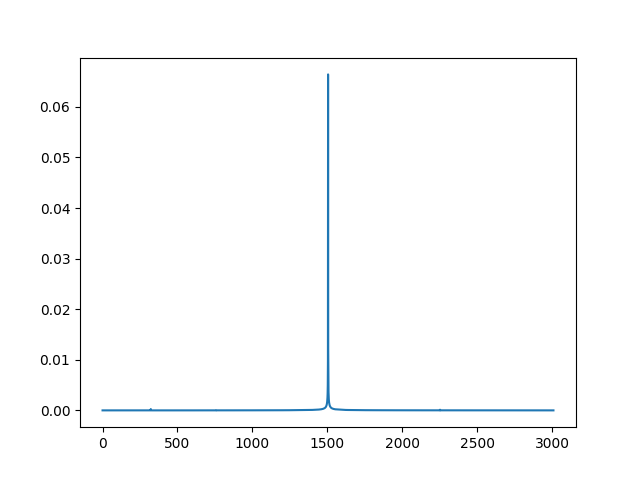

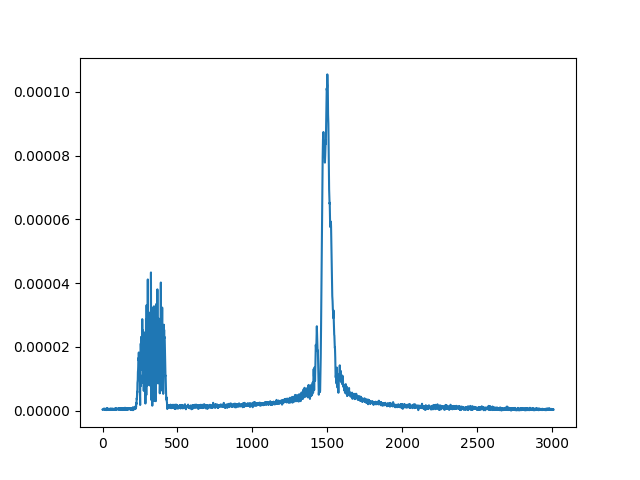

In [6]:
from pilottone.signal import to_hybrid_kspace
plt.figure()
plt.plot(np.abs(to_hybrid_kspace(ksp_cal[:,0,0])), label='Calibration PT')

plt.figure()
plt.plot(np.abs(to_hybrid_kspace(ksp_measured[:,0,0])), label='Measured PT')

# Plot coils and raw PT

In [7]:
from matplotlib.patches import Circle
from mpl_toolkits.mplot3d import art3d
from typing import Tuple

def draw_coils(axs, coil_name, colors, draw3d=False):

    if draw3d:
        all_coils = {
        'Body_6:1:B11': [+1, 1.5, 1], 'Body_6:1:B12': [+0, 1.5, 1], 'Body_6:1:B13': [-1, 1.5, 1],
        'Body_6:1:B21': [+1, 0.5, 1], 'Body_6:1:B22': [+0, 0.5, 1], 'Body_6:1:B23': [-1, 0.5, 1],
        'Spine_18:1:S1P': [+1, +1.5, -1], 'Spine_18:1:S1S': [0, +1.5, -1], 'Spine_18:1:S1T': [-1, +1.5, -1],
        'Spine_18:1:S2P': [+1, +0.5, -1], 'Spine_18:1:S2S': [0, +0.5, -1], 'Spine_18:1:S2T': [-1, +0.5, -1],
        'Spine_18:1:S3P': [+1,  -0.5, -1], 'Spine_18:1:S3S': [0,  -0.5, -1], 'Spine_18:1:S3T': [-1,  -0.5, -1],
        'Spine_18:1:S4P': [+1, -1.5, -1], 'Spine_18:1:S4S': [0, -1.5, -1], 'Spine_18:1:S4T': [-1, -1.5, -1]
        }
    else:
        all_coils = {
            'Body_6:1:B11': [+1, 5], 'Body_6:1:B12': [+0, 5], 'Body_6:1:B13': [-1, 5],
            'Body_6:1:B21': [+1, 4], 'Body_6:1:B22': [+0, 4], 'Body_6:1:B23': [-1, 4],
            'Spine_18:1:S1P': [+1, +2], 'Spine_18:1:S1S': [0, +2], 'Spine_18:1:S1T': [-1, +2],
            'Spine_18:1:S2P': [+1, +1], 'Spine_18:1:S2S': [0, +1], 'Spine_18:1:S2T': [-1, +1],
            'Spine_18:1:S3P': [+1,  0], 'Spine_18:1:S3S': [0,  0], 'Spine_18:1:S3T': [-1,  0],
            'Spine_18:1:S4P': [+1, -1], 'Spine_18:1:S4S': [0, -1], 'Spine_18:1:S4T': [-1, -1]
            }
        
    for i, coil in enumerate(coil_name):
        if coil in all_coils:
            # print(f'Coil: {coil}, Position: {all_coils[coil]}')
            # Create a circle for each coil position
            circle = Circle(all_coils[coil][:2], radius=0.5, color=colors[i], fill=False, lw=2)
            axs.add_patch(circle)
            if draw3d:
                art3d.pathpatch_2d_to_3d(circle, z=all_coils[coil][2], zdir="z")
                axs.text(all_coils[coil][0], all_coils[coil][1], all_coils[coil][2], coil[-3:], fontsize=12, ha='center', va='center')
            else:
                axs.text(all_coils[coil][0], all_coils[coil][1], coil[-3:], fontsize=12, ha='center', va='center')


    axs.axis('equal')

    if draw3d:
        axs.text(2.3, 0, 0, 'Patient\nLeft', fontsize=14, ha='center', va='center')
        axs.text(-2.3, 0, 0, 'Patient\nRight', fontsize=14, ha='center', va='center')
        axs.set_xlim(-4, 4)
        axs.set_ylim(-4, 4)
        axs.set_zlim(-2, 2)
        axs.view_init(elev=30., azim=-80, roll=0)
        axs.set_box_aspect(None, zoom=2)
    else:
        axs.set_xlim(-10, 10)
        axs.set_ylim(-4, 8)
        axs.text(2.3, 2, 'Patient\nLeft', fontsize=14, ha='center', va='center')
        axs.text(-2.3, 2, 'Patient\nRight', fontsize=14, ha='center', va='center')

    axs.axis('off')


def plot_rawpt(pt_raw: np.ndarray, coil_name: np.ndarray, time_pt: np.ndarray, sort: bool=True, drawcoils: bool = True, colors: list[str] | None = None, draw3d=False) -> Tuple[plt.Figure, np.ndarray]:
    if sort:
        Isort = np.argsort(coil_name)
    else:
        Isort = np.arange(pt_raw.shape[1])
    ptb = np.linspace(14e-4, -14e-4, pt_raw.shape[1])
    if drawcoils:
        if draw3d:
            f = plt.figure()
            axs = [f.add_subplot(121), f.add_subplot(122, projection='3d')]
        else:
            f, axs = plt.subplots(1,2)
    else: 
        f, axs = plt.subplots(1,1)
    axs = np.atleast_1d(axs)
    f.set_size_inches(10, 10)
    if colors is not None:
        axs[0].set_prop_cycle(color=colors)
    lines = axs[0].plot(time_pt, ptb+pt_raw[:,Isort])
    for i, coil in enumerate((coil_name)[Isort]):
        axs[0].text(time_pt[-1]*1.1, ptb[i], coil[-3:], fontsize=12, ha='right', va='center', color=lines[i].get_color())
    axs[0].set_xlabel('Time [s]')

    axs[0].set_xlim(0, time_pt[-1]+10)
    axs[0].set_yticks([])
    default_colors = [line.get_color() for line in lines]
    if drawcoils:
        draw_coils(axs[1], (coil_name)[Isort], default_colors, draw3d=draw3d)
    plt.suptitle('Raw Pilot Tones and coil positions', fontsize=16)
    plt.tight_layout()
    return f, axs

In [8]:
# Colors coded by coil position
colors_pos = ["#0000d6", "#008b00", "#e54304",
              "#1c00db", "#09af00", "#ee6002",
              "#3d00e0", "#41c300", "#f47100",
              "#5300e8", "#61d800", "#fa8100",
              "#6002ee", "#75e900", "#ff8d00",
              "#7e3ff2", "#90ee02", "#ff9e22"]

/server/home/btasdelen/workspace/PyPilotTone/venv/lib/python3.10/site-packages/traitlets/traitlets.py:1385: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
NavigationToolbar2WebAgg.__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  warn(
/tmp/ipykernel_148677/3629292015.py:30: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Default colors used in the plot: ['#0000d6', '#008b00', '#e54304', '#1c00db', '#09af00', '#ee6002', '#3d00e0', '#41c300', '#f47100', '#5300e8', '#61d800', '#fa8100', '#6002ee', '#75e900', '#ff8d00']


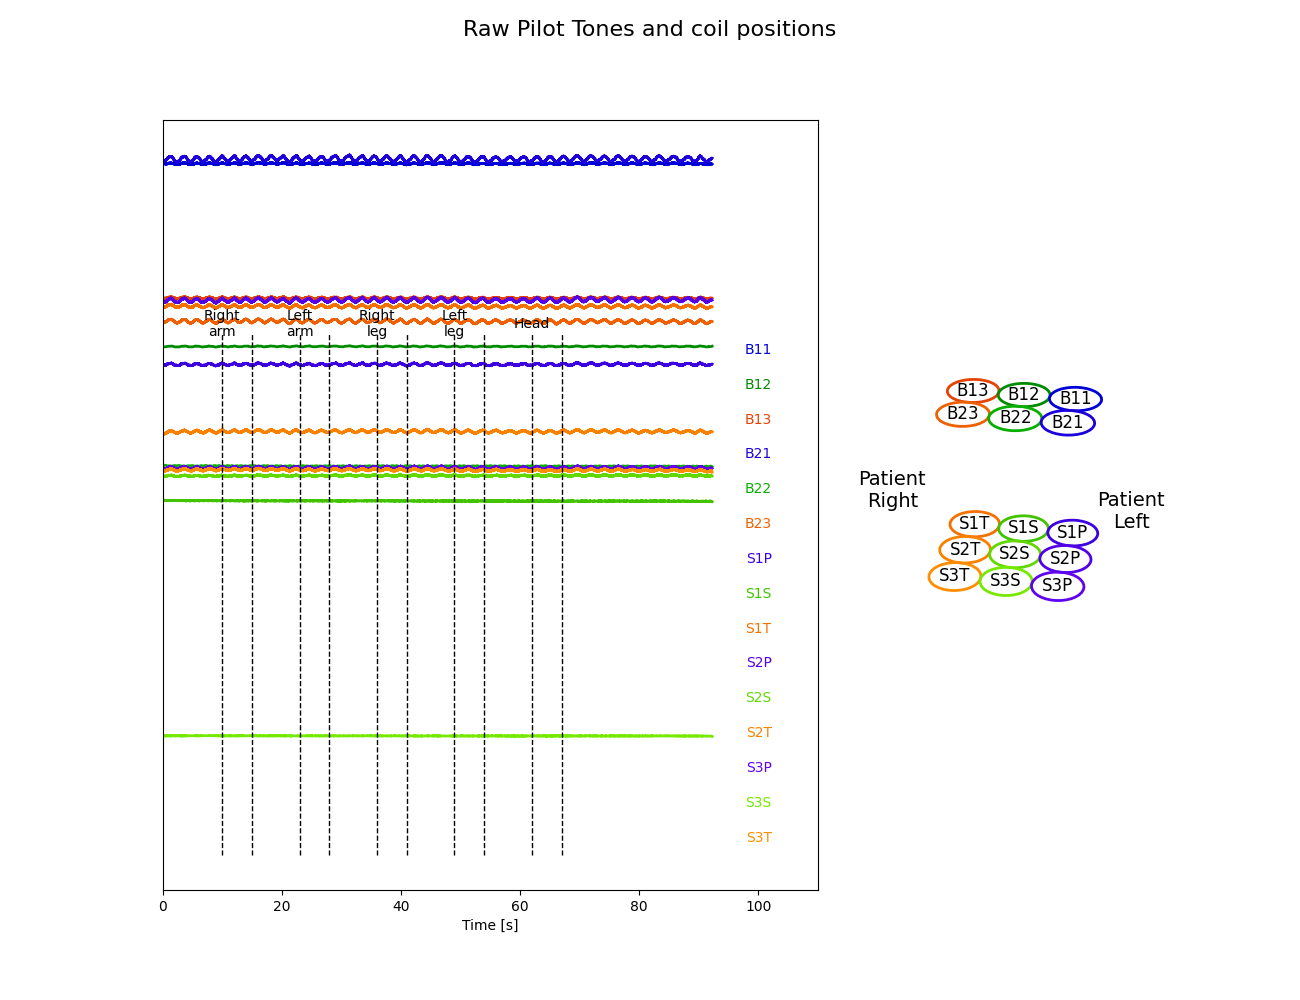

In [30]:
Isort = np.argsort(coil_name[mri_coils])
ptb = np.linspace(14e-4, -14e-4, pt_raw.shape[1])
pt_raw_filt = savgol_filter(pt_raw, 81, 3, axis=0)
f = plt.figure(figsize=(13, 10))
gs = f.add_gridspec(1,2, width_ratios=[2, 1], wspace=0.05)
axs = [f.add_subplot(gs[0]), f.add_subplot(gs[1], projection='3d')]

axs[0].set_prop_cycle(color=colors_pos)
lines = axs[0].plot(time_pt, ptb+pt_raw_filt[:,Isort], lw=2)
for i, coil in enumerate((coil_name[mri_coils])[Isort]):
    axs[0].text(time_pt[-1]+10, ptb[i], coil[-3:], fontsize=10, ha='right', va='center', color=lines[i].get_color())
# plt.legend(coil_name[mri_coils])
axs[0].set_xlabel('Time [s]')

# Movement sequence
# Right arm, left arm, right leg, left leg, head
fontsize_small = 10
axs[0].vlines([10, 15, 23, 28, 36, 41, 49, 54, 62, 67], ymin=ptb[-1]-1e-4, ymax=ptb[0]+1e-4, color='k', lw=1, linestyle='--')
axs[0].text(10, ptb[0]+1.5e-4, 'Right\narm', fontsize=fontsize_small, ha='center', va='center')
axs[0].text(23, ptb[0]+1.5e-4, 'Left\narm', fontsize=fontsize_small, ha='center', va='center')
axs[0].text(36, ptb[0]+1.5e-4, 'Right\nleg', fontsize=fontsize_small, ha='center', va='center')
axs[0].text(49, ptb[0]+1.5e-4, 'Left\nleg', fontsize=fontsize_small, ha='center', va='center')
axs[0].text(62, ptb[0]+1.5e-4, 'Head', fontsize=fontsize_small, ha='center', va='center')
axs[0].set_xlim(0, 110)
axs[0].set_yticks([])
default_colors = [line.get_color() for line in lines]
print("Default colors used in the plot:", default_colors)
draw_coils(axs[1], (coil_name[mri_coils])[Isort], default_colors, draw3d=True)
plt.suptitle('Raw Pilot Tones and coil positions', fontsize=16)
plt.tight_layout()
plt.savefig('raw_pt_coil_positions.svg', dpi=300)
plt.show()

## Shortened version

/server/home/btasdelen/workspace/PyPilotTone/venv/lib/python3.10/site-packages/traitlets/traitlets.py:1385: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
NavigationToolbar2WebAgg.__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  warn(


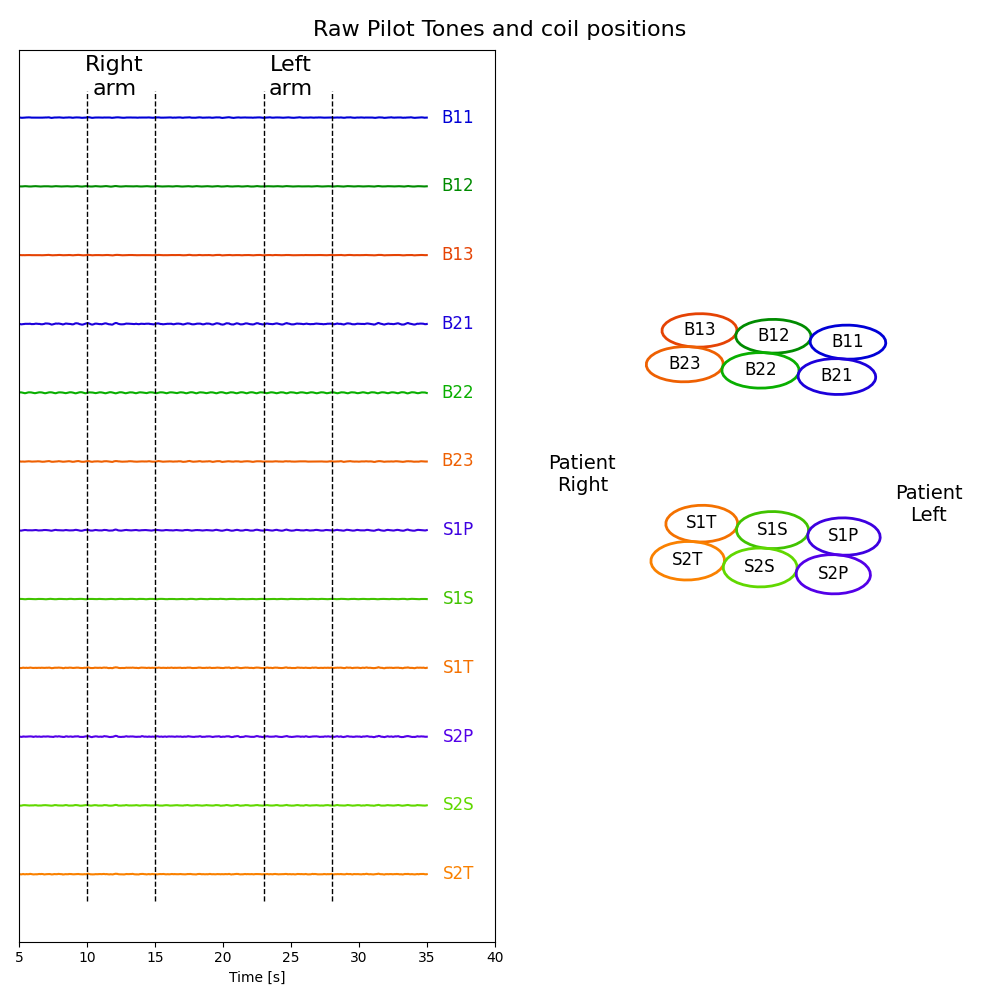

In [39]:
ff, aaxs = plot_rawpt(pt_cardiac_freqs[(time_pt<35) & (time_pt>5),:-3], (coil_name[mri_coils])[:-3], time_pt[(time_pt<35) & (time_pt>5)], sort=True, drawcoils=True, colors=colors_pos, draw3d=True)
fontsize_small = 16
# aaxs[0].vlines([10, 15, 23, 28, 36, 41, 49, 54, 62, 67], ymin=ptb[-1]-1e-4, ymax=ptb[0]+1e-4, color='k', lw=1, linestyle='--')
aaxs[0].vlines([10, 15, 23, 28], ymin=ptb[-1]-1e-4, ymax=ptb[0]+1e-4, color='k', lw=1, linestyle='--')

aaxs[0].text(12, ptb[0]+1.5e-4, 'Right\narm', fontsize=fontsize_small, ha='center', va='center')
aaxs[0].text(25, ptb[0]+1.5e-4, 'Left\narm', fontsize=fontsize_small, ha='center', va='center')
# aaxs[0].text(36, ptb[0]+1.5e-4, 'Right\nleg', fontsize=fontsize_small, ha='center', va='center')
# aaxs[0].text(49, ptb[0]+1.5e-4, 'Left\nleg', fontsize=fontsize_small, ha='center', va='center')
# aaxs[0].text(62, ptb[0]+1.5e-4, 'Head', fontsize=fontsize_small, ha='center', va='center')
aaxs[0].set_xlim(5, 40)
aaxs[0].set_yticks([])
plt.savefig('raw_pt_coil_positions_zoomed.svg', dpi=300)

# Modulation percentages

In [28]:
print(np.mean(pt_raw, axis=0))

[0.00021997 0.00069869 0.00169692 0.00106945 0.00116435 0.00013273
 0.00111711 0.00053289 0.0012783  0.00208634 0.00185026 0.00173214
 0.00172313 0.00038394 0.0021105 ]


In [40]:
def modulation_percentage(raw_pt: np.ndarray) -> np.ndarray:
    """
    Calculate the modulation percentage of the pilot tone signal.
    The modulation percentage is defined as the ratio of the standard deviation
    of the signal to its mean value, expressed as a percentage.
    """
    # Calculate the mean and standard deviation of the raw pilot tone signal
    mean_pt = np.mean(raw_pt, axis=0)
    max_pt = np.max(raw_pt, axis=0)
    min_pt = np.min(raw_pt, axis=0)

    # Calculate the modulation percentage
    mod_percentage = ((max_pt-min_pt) / mean_pt) * 100

    return mod_percentage

print("Modulation percentage of the pilot tone signal:")
mean_pt = np.mean(pt_raw, axis=0)
mod_percentage = modulation_percentage(pt_raw_filt)
f_samp = 1/samp_time_pt # [Hz]
filt_bp_cardiac = pt.signal.designbp_tukeyfilt_freq(1, 20, f_samp, pt_raw_filt.shape[0])

pt_cardiac_freqs = pt.signal.apply_filter_freq(pt_raw_filt, filt_bp_cardiac, 'symmetric')
cardiac_mod_percentage = ((np.max(pt_cardiac_freqs,axis=0)-np.min(pt_cardiac_freqs, axis=0)) / mean_pt) * 100

for i, coil in enumerate(coil_name[mri_coils]):
    print(f"Coil: {coil}, Modulation percentage: {mod_percentage[i]:.2f}%, Cardiac modulation percentage: {cardiac_mod_percentage[i]:.2f}%")
    # print(f"Coil: {coil}, Modulation percentage: {mod_percentage[i]:.2f}%")
    # print(f"Coil: {coil}, Cardiac modulation percentage: {cardiac_mod_percentage[i]:.2f}%")

Modulation percentage of the pilot tone signal:
Coil: Body_6:1:B12, Modulation percentage: 3.43%, Cardiac modulation percentage: 1.45%
Coil: Body_6:1:B13, Modulation percentage: 1.86%, Cardiac modulation percentage: 0.94%
Coil: Body_6:1:B21, Modulation percentage: 2.58%, Cardiac modulation percentage: 1.26%
Coil: Body_6:1:B11, Modulation percentage: 1.71%, Cardiac modulation percentage: 1.03%
Coil: Body_6:1:B23, Modulation percentage: 2.59%, Cardiac modulation percentage: 1.12%
Coil: Body_6:1:B22, Modulation percentage: 9.31%, Cardiac modulation percentage: 3.44%
Coil: Spine_18:1:S1P, Modulation percentage: 1.77%, Cardiac modulation percentage: 0.82%
Coil: Spine_18:1:S1S, Modulation percentage: 2.13%, Cardiac modulation percentage: 1.00%
Coil: Spine_18:1:S2S, Modulation percentage: 1.01%, Cardiac modulation percentage: 0.74%
Coil: Spine_18:1:S2P, Modulation percentage: 1.77%, Cardiac modulation percentage: 0.73%
Coil: Spine_18:1:S1T, Modulation percentage: 1.33%, Cardiac modulation per

 ## QA and ECG PT Jitter

Using Body_6:1:B23 as the initial cardiac coil.
Number of channels selected for respiratory PT: 10
Number of channels selected for cardiac PT: 4
Rejection ratio for pt peaks is 2.17 percent.

Rejection ratio for derivative pt peaks is 1.11 percent.

Peak difference 338.3 ± 103.9
Derivative peak difference 152.1 ± 78.0
Number of ECG triggers: 80.
Number of PT triggers: 92.
Number of missed PT triggers: 0.
Number of extraneous PT triggers: 13.
Number of derivative PT triggers: 90.
Number of missed derivative PT triggers: 2.
Number of extraneous derivative PT triggers: 12.


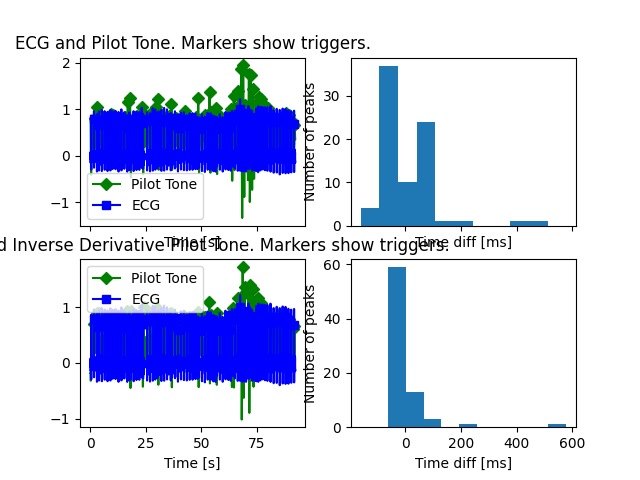

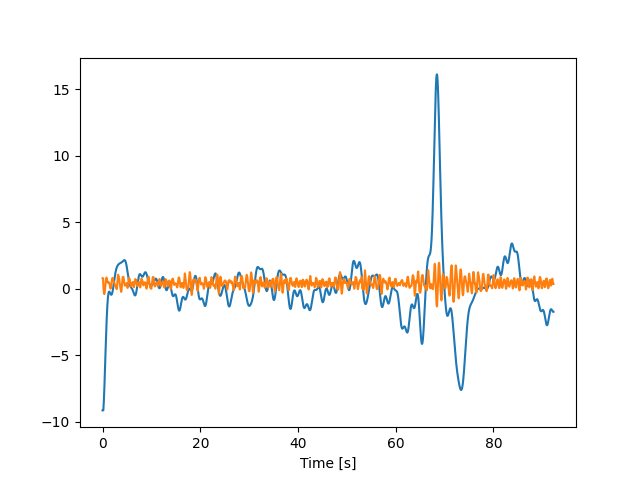

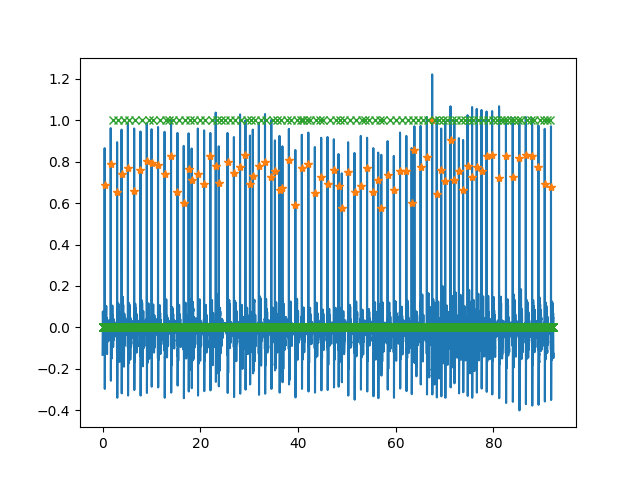

In [32]:
f_samp = 1/samp_time_pt # [Hz]
print(f"Using {cfg['pilottone']['cardiac']['initial_channel']} as the initial cardiac coil.")
pt_extract_params = {'golay_filter_len': cfg['pilottone']['golay_filter_len'],
                    'respiratory': {
                            'freq_start': cfg['pilottone']['respiratory']['freq_start'],
                            'freq_stop': cfg['pilottone']['respiratory']['freq_stop'],
                            'corr_threshold': cfg['pilottone']['respiratory']['corr_threshold'],
                            'corr_init_ch': cfg['pilottone']['respiratory']['initial_channel'],
                            'separation_method': cfg['pilottone']['respiratory']['separation_method'], # 'sobi', 'pca'
                    },
                    'cardiac': {
                                'freq_start': cfg['pilottone']['cardiac']['freq_start'],
                                'freq_stop': cfg['pilottone']['cardiac']['freq_stop'],
                                'corr_threshold': cfg['pilottone']['cardiac']['corr_threshold'],
                                'corr_init_ch': np.nonzero(coil_name == cfg['pilottone']['cardiac']['initial_channel'])[0][0],                           
                                'separation_method': cfg['pilottone']['cardiac']['separation_method'], # 'sobi', 'pca'

                    },
                    'debug': {
                        'selected_coils': cfg['pilottone']['debug']['selected_coils'],
                        'coil_legend': coil_name[mri_coils],
                        'show_plots': cfg['pilottone']['debug']['show_plots'],
                        'no_normalize': cfg['pilottone']['debug']['no_normalize'],
                    }
                }

sg_filter_len = 81

# pt_respiratory, pt_cardiac = pt.extract_pilottone_navs(pt_raw, f_samp, pt_extract_params)
Vresp, accept_list_resp, pt_respiratory_cal, Vcard, accept_list_cardiac, pt_cardiac_cal = pt.calibrate_pt(pt_raw[(time_pt>20)&(time_pt<40),:], f_samp, pt_extract_params)
pt_respiratory, pt_cardiac = pt.apply_pt_calib(pt_raw, Vresp, accept_list_resp, Vcard.T, accept_list_cardiac, f_samp, pt_extract_params)

time_pt2 = time_pt

pt_cardiac = cfg['pilottone']['cardiac']['sign']*pt_cardiac
pt_cardiac[:20] = pt_cardiac[20]
pt_cardiac[-20:] = pt_cardiac[-20]
pt_cardiac -= np.percentile(pt_cardiac, 10)
pt_cardiac /= np.percentile(pt_cardiac, 95)

pt_respiratory[:30] = pt_respiratory[30]
pt_respiratory[-20:] = pt_respiratory[-20]

pt_cardiac_filtered = savgol_filter(pt_cardiac, sg_filter_len, 3, axis=0)
pt_cardiac_derivative = np.hstack((0, np.diff(pt_cardiac_filtered)/(time_pt[1] - time_pt[0])))
pt_cardiac_derivative[:20] = pt_cardiac_derivative[20]
pt_cardiac_derivative[-20:] = pt_cardiac_derivative[-20]
pt_cardiac_derivative -= np.percentile(pt_cardiac_derivative, 10)
pt_cardiac_derivative /= np.percentile(pt_cardiac_derivative, 98)

pt_cardiac_trigs = extract_triggers(time_pt2, pt_cardiac, skip_time=1, prominence=0.4, max_hr=160)
pt_derivative_trigs = extract_triggers(time_pt2, pt_cardiac_derivative, skip_time=1, prominence=0.5, max_hr=160)

if ecg is not None:
    _,_ = pt_ecg_jitter(time_pt2, pt_cardiac, pt_cardiac_derivative,
                        time_ecg, ecg_waveform, 
                        pt_cardiac_trigs=pt_cardiac_trigs, pt_derivative_trigs=pt_derivative_trigs, ecg_trigs=ecg_trigs, 
                        skip_time=1, show_outputs=cfg['pilottone']['show_outputs'])
    plt.figure()
    plt.plot(time_pt2, pt_respiratory*10, label='Respiratory')
    plt.plot(time_pt2, pt_cardiac, label='Cardiac')

    plt.xlabel('Time [s]')
    plt.show()
elif ecg is None and cfg['pilottone']['show_outputs']:
    fig, axs = plt.subplots(2,1, figsize=(10, 6), sharex=True)
    axs[0].plot(time_pt2, pt_cardiac, label='Cardiac')
    axs[0].plot(time_pt2, pt_cardiac_derivative, label='Cardiac Derivative')
    axs[0].plot(time_pt2[pt_cardiac_trigs==1], pt_cardiac[pt_cardiac_trigs==1], '*', label='Cardiac Triggers')
    axs[0].plot(time_pt2[pt_derivative_trigs==1], pt_cardiac_derivative[pt_derivative_trigs==1], '*', label='Cardiac Derivative Triggers')
    axs[0].set_title('Cardiac Triggers')
    axs[0].set_xlabel('Time [s]')
    axs[0].legend()
    axs[1].plot(time_pt2, pt_respiratory, label='Respiratory')
    axs[1].set_title('Respiratory')
    axs[1].set_xlabel('Time [s]')
    axs[1].legend()
    plt.show()



/server/home/btasdelen/workspace/PyPilotTone/venv/lib/python3.10/site-packages/traitlets/traitlets.py:1385: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
NavigationToolbar2WebAgg.__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  warn(


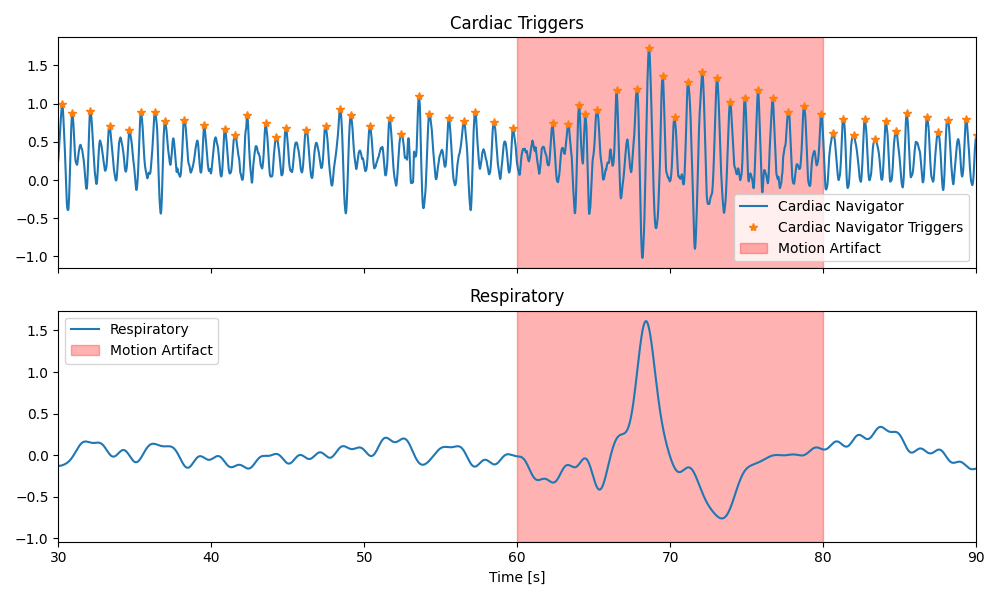

In [35]:
fig, axs = plt.subplots(2,1, figsize=(10, 6), sharex=True)
axs[0].plot(time_pt2, pt_cardiac_derivative, label='Cardiac Navigator')
axs[0].plot(time_pt2[pt_derivative_trigs==1], pt_cardiac_derivative[pt_derivative_trigs==1], '*', label='Cardiac Navigator Triggers')
axs[0].axvspan(60, 80, color='red', alpha=0.3, label='Motion Artifact')
axs[0].set_title('Cardiac Triggers')
axs[0].legend()
axs[0].set_xlim(30, 90)
axs[1].plot(time_pt2, pt_respiratory, label='Respiratory')
# add a shaded area around 60 to 80 seconds
axs[1].axvspan(60, 80, color='red', alpha=0.3, label='Motion Artifact')
axs[1].set_title('Respiratory')
axs[1].set_xlabel('Time [s]')
axs[1].set_xlim(30, 90)
axs[1].legend()
plt.tight_layout()
plt.savefig('Motion_artifact_arrp3.svg', dpi=300)
plt.show()

# Plot filters

(0.0, 20.0)

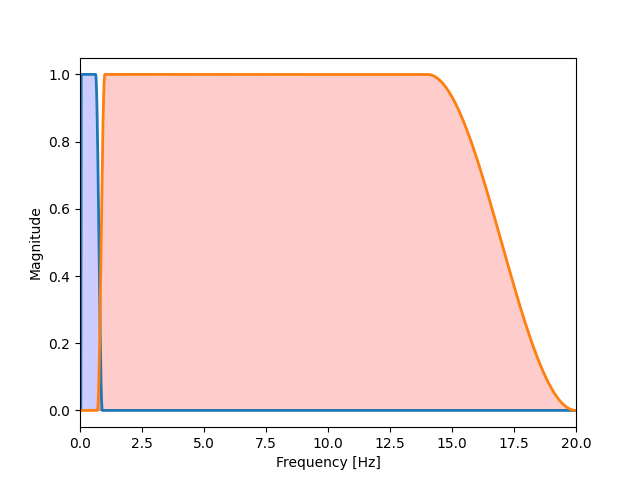

In [19]:
from pilottone.pt import designbp_tukeyfilt_freq

n_pt_samp = pt_raw.shape[0]

dt_pt = 1/f_samp
df = f_samp/n_pt_samp/2
f_filt = np.arange(0, f_samp, df) - (f_samp - (n_pt_samp % 2)*df)/2 # Handles both even and odd length signals.
f_pos = np.where(f_filt >= 0)[0]

filt_bp_resp = designbp_tukeyfilt_freq(pt_extract_params['respiratory']['freq_start'], pt_extract_params['respiratory']['freq_stop'], f_samp, n_pt_samp)
filt_bp_cardiac = designbp_tukeyfilt_freq(pt_extract_params['cardiac']['freq_start'], pt_extract_params['cardiac']['freq_stop'], f_samp, n_pt_samp)


plt.figure()
plt.plot(f_filt[f_pos], np.abs(filt_bp_resp[f_pos]), label='Respiratory filter', linewidth=2)
plt.plot(f_filt[f_pos], np.abs(filt_bp_cardiac[f_pos]), label='Cardiac filter', linewidth=2)
plt.fill(f_filt[f_pos], np.abs(filt_bp_resp[f_pos]), color='blue', alpha=0.2)
plt.fill(f_filt[f_pos], np.abs(filt_bp_cardiac[f_pos]), color='red', alpha=0.2)
plt.xlabel('Frequency [Hz]')
plt.ylabel('Magnitude')
plt.xlim(0, 20)

# Spatial spectral

/server/home/btasdelen/workspace/PyPilotTone/venv/lib/python3.10/site-packages/traitlets/traitlets.py:1385: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
NavigationToolbar2WebAgg.__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  warn(


(0.0, 20.0)

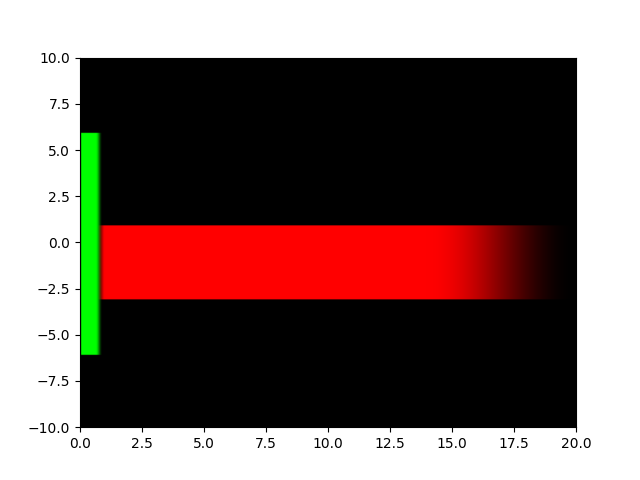

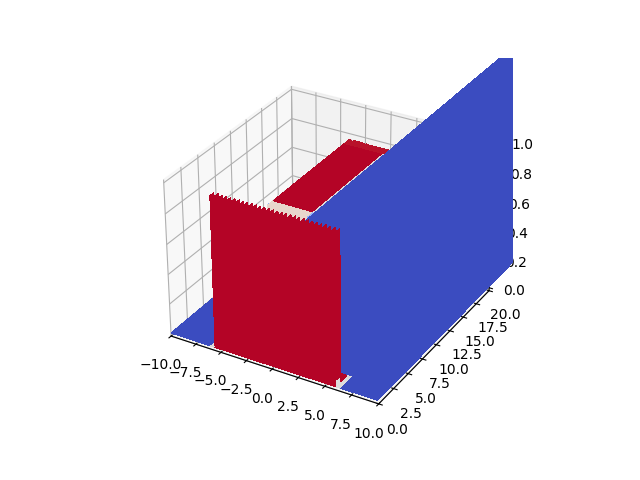

In [29]:
from matplotlib import cm
x_full = np.arange(-10, 10, 0.1)
x_r_accept = np.logical_and(x_full < 6, x_full > -6)
x_c_accept = np.logical_and(x_full < 3, x_full > -1)

heatm_r = x_r_accept[:,None]*filt_bp_resp[f_pos,:].T
heatm_c = x_c_accept[:,None]*filt_bp_cardiac[f_pos,:].T
plt.figure()
plt.imshow(np.concatenate((heatm_c[:,:,None], heatm_r[:,:,None], np.zeros_like(heatm_c[:,:,None])), axis=2), aspect='auto', cmap='gray', extent=[0, f_filt[-1], -10, 10])
plt.xlim(0, 20)

X, Y = np.meshgrid(x_full, f_filt[f_pos])
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.plot_surface(X, Y, heatm_c.T, cmap=cm.coolwarm, antialiased=False)
ax.plot_surface(X, Y, heatm_r.T, cmap=cm.coolwarm, antialiased=False)
ax.set_xlim(-10, 10)
ax.set_ylim(0, 20)



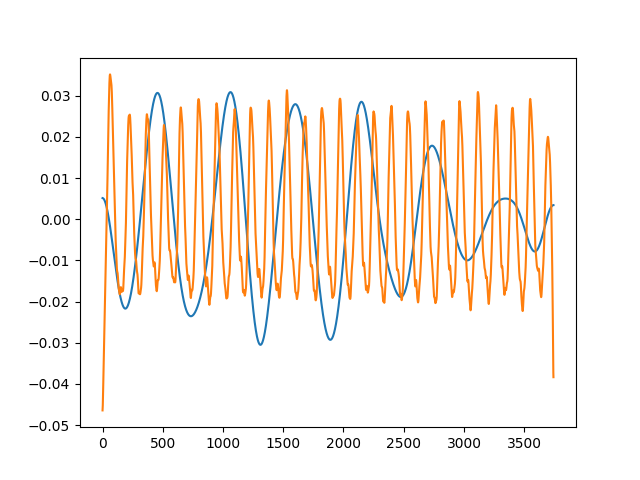

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


(<Figure size 1000x1000 with 2 Axes>,
 array([<Axes: xlabel='Time [s]'>, <Axes: >], dtype=object))

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


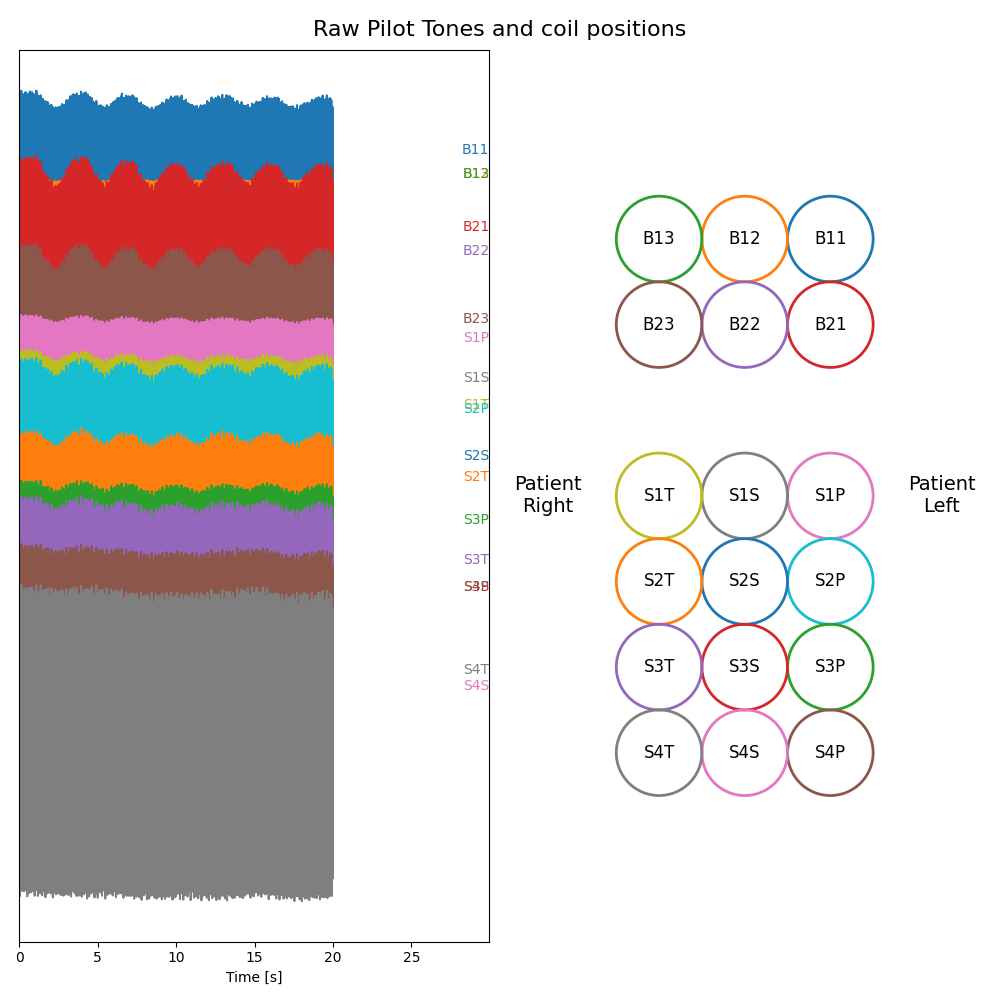

In [27]:
plt.figure()
plt.plot(pt_respiratory_cal, label='Respiratory Calibration')
plt.plot(pt_cardiac_cal, label='Cardiac Calibration')
plt.show()

plot_rawpt(pt_raw_cal, coil_name[mri_coils], np.arange(pt_raw_cal.shape[0])*(time_pt[1]), sort=True, drawcoils=True)


In [246]:
import copy
pt_extract_params2 = copy.deepcopy(pt_extract_params)
pt_extract_params2['cardiac']['freq_stop'] = 6
Vresp, accept_list_resp, pt_respiratory_cal, Vcard, accept_list_cardiac, pt_cardiac_cal = pt.calibrate_pt(pt_raw_cal, f_samp, pt_extract_params)
print(Vcard)
Vresp, accept_list_resp, pt_respiratory_cal, Vcard, accept_list_cardiac, pt_cardiac_cal = pt.calibrate_pt(pt_raw_cal, f_samp, pt_extract_params2)
print(Vcard)


Number of channels selected for respiratory PT: 11
Number of channels selected for cardiac PT: 2
[[-0.7360932  -0.67688019]]
Number of channels selected for respiratory PT: 11
Number of channels selected for cardiac PT: 2
[[-0.76025981 -0.64961914]]


## Try rovir

In [28]:
from typing import Tuple
from scipy.linalg import eigh
import matplotlib.widgets as mwidgets

def calc_rovir(pt: np.ndarray, signal_mask: np.ndarray, interference_mask: np.ndarray) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """
    Calculate the ROVIR coils from the pilot tone data and masks.
    
    Parameters
    ----------
    pt : np.ndarray
        Pilot tone data.
    signal_mask : np.ndarray
        Mask for the signal.
    interference_mask : np.ndarray
        Mask for the interference.
        
    Returns
    -------
    Tuple[np.ndarray, np.ndarray]
        ROVIR for the respiratory and cardiac signals.
    """
    
    # Calculate the ROVIR for respiratory and cardiac signals
    pt_signal = pt[signal_mask, :]
    pt_interference = pt[interference_mask, :]

    # Calculate A and B matrices
    A = pt_signal.T@pt_signal
    B = pt_interference.T@pt_interference

    # Solve for generalized eigenvalues
    D, V = eigh(A, B)

    idx = np.argsort(D)[::-1]  # Sort eigenvalues in descending order
    Vrvr = V[:, idx]  # Sort eigenvectors accordingly
    Vrvr /= np.linalg.vector_norm(Vrvr, axis=0, keepdims=True, ord=2)  # Normalize eigenvectors
    
    # Transform PT to the new basis
    pt_rvr = pt @ Vrvr

    # Calculate SNR and SIR
    nc = Vrvr.shape[1]
    SNR = np.zeros(nc)
    SIR = np.zeros(nc)
    for c_i in range(nc):
        W = Vrvr[:, c_i]
        SNR[c_i] = abs((W.T @ A @ W) / (W.T @ W))
        SIR[c_i] = abs((W.T @ A @ W) / (W.T @ B @ W))
    
    return Vrvr, pt_rvr, SIR, SNR

def onselect(vmin, vmax):
    print('Test')
    print(vmin, vmax)

def pick_regions(ax, n_interference: int=4):
    # f, axs = plot_rawpt(pt_raw, coil_name, time_pt)
    axs[0].set_title('Select regions for signal and interference', fontsize=16)
    # Interactive selection of regions

    span = mwidgets.SpanSelector(ax, onselect, 'horizontal',
                             props=dict(facecolor='blue', alpha=0.5), interactive=True)
    return span



In [29]:
# TODO: Make interactive selection of regions for signal and interference
10, 15, 23, 28, 36, 41, 49, 54, 62, 67
interference_mask = (time_pt > 10) & (time_pt < 15) | \
                    (time_pt > 23) & (time_pt < 28) | \
                    (time_pt > 36) & (time_pt < 41) | \
                    (time_pt > 49) & (time_pt < 54) | \
                    (time_pt > 62) & (time_pt < 67)
signal_mask = ~interference_mask
pt_raw_filt = savgol_filter(pt_raw, 81, 3, axis=0)
Vrvr, pt_rvr, SIR, SNR = calc_rovir(pt_raw_filt, signal_mask, interference_mask)

In [249]:
np.linalg.vector_norm(Vrvr, axis=0, keepdims=True, ord=2)  # Normalize eigenvectors

array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.]])

In [147]:
np.linalg.vector_norm(Vrvr, axis=0, keepdims=True, ord=2)

array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.]])

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


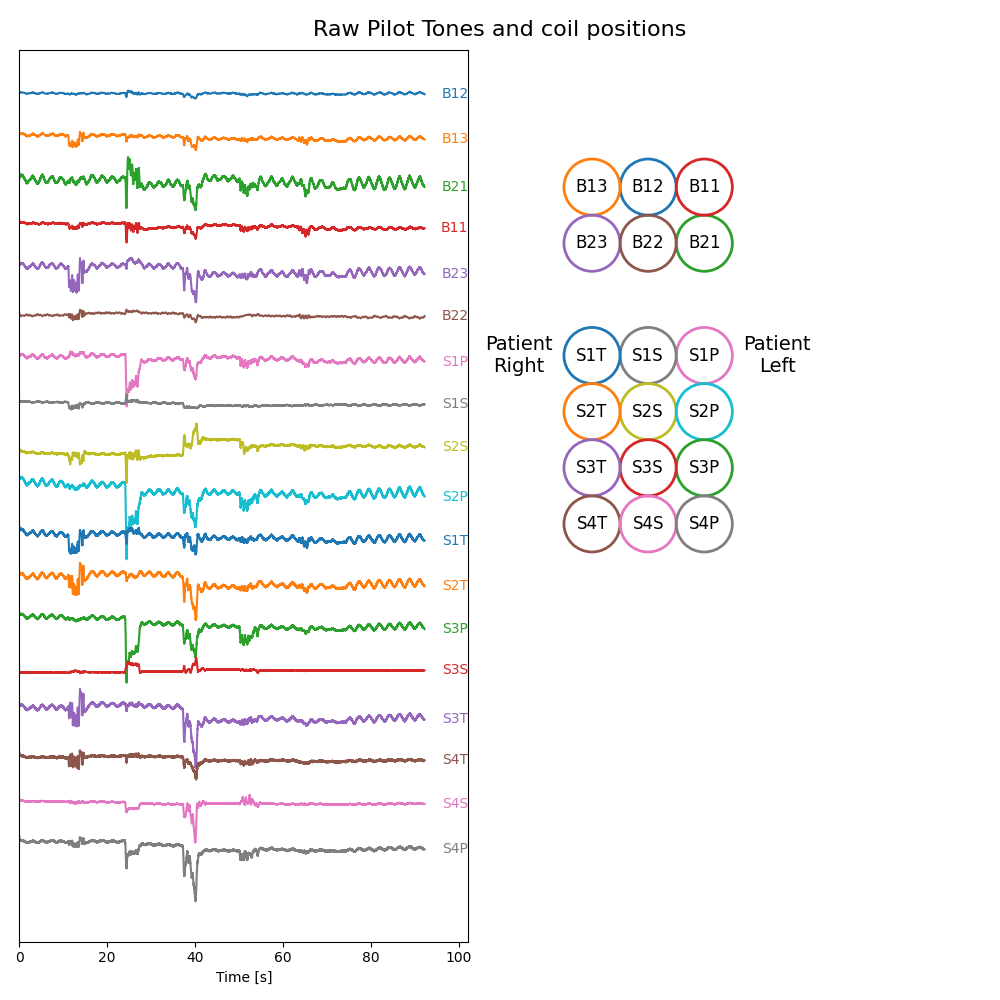

In [250]:
f, axs = plot_rawpt(pt_raw_filt, coil_name[mri_coils], time_pt, sort=False)


Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


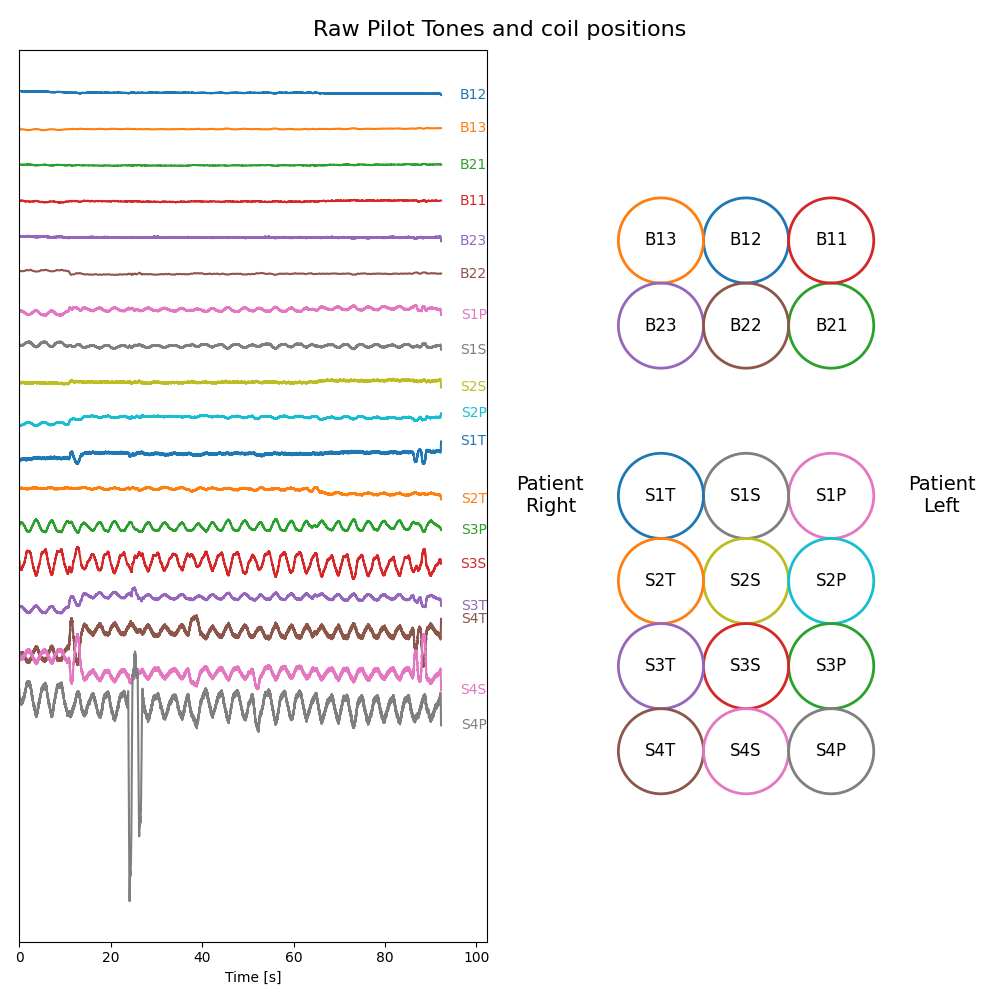

In [30]:
from scipy.linalg import qr
from scipy.linalg import inv
Vrvr2,_ = qr(Vrvr)
f, axs = plot_rawpt(pt_raw_filt@Vrvr2, coil_name[mri_coils], time_pt, sort=False)
cumSNR = np.cumsum(SNR)
cumSNR /= cumSNR[-1]  # Normalize SNR for plotting
# Make separate y axis for SNR and SIR
# plt.figure()
# plt.plot(cumSNR, label='SNR', color='red')
# ax2 = plt.twinx(plt.gca())
# ax2.plot(SIR, label='SIR')
# ax2.set_xticks(np.arange(len(SIR)))
# plt.xlabel('Coil number')
# plt.legend()
# plt.show()

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


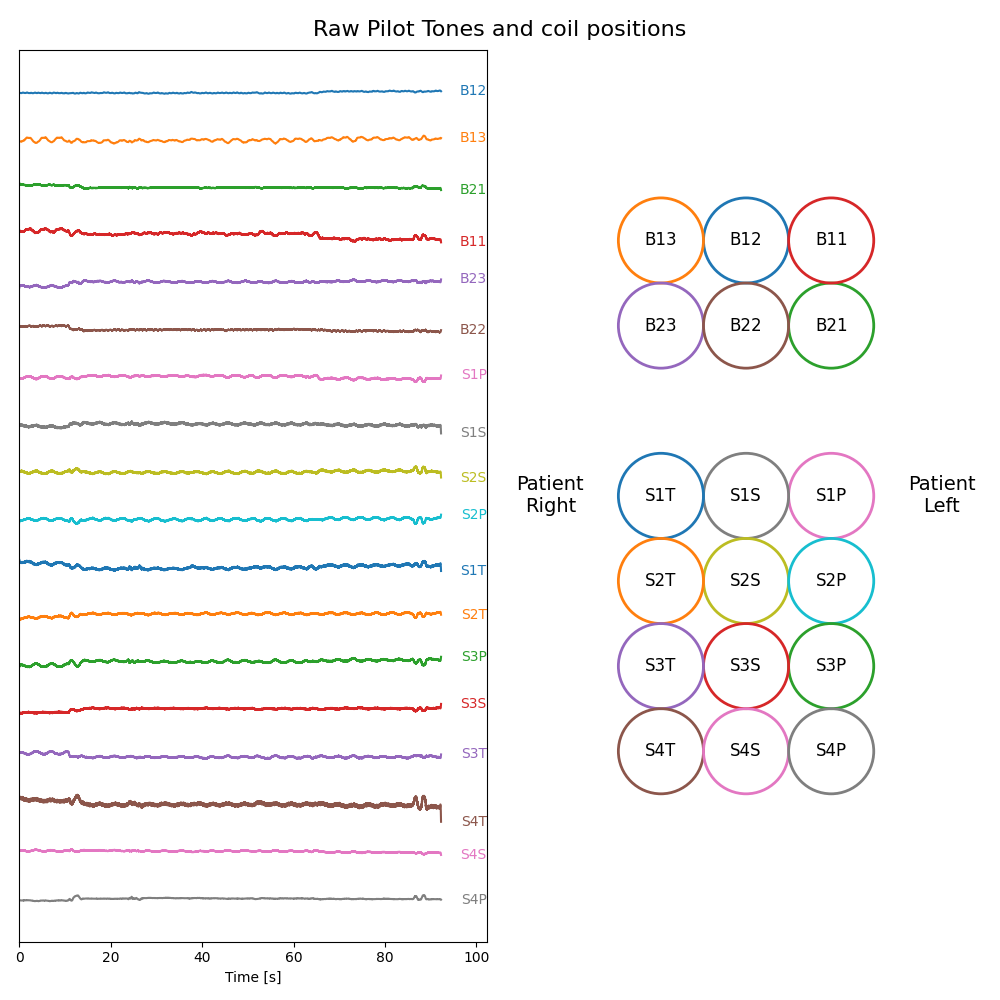

In [71]:
from scipy.linalg import pinv
pt_raw2 = (pt_raw_filt @ Vrvr[:, :12]) @ pinv(Vrvr[:, :12])
f, axs = plot_rawpt(pt_raw2, coil_name[mri_coils], time_pt, sort=False)

In [49]:
pt_extract_params

{'golay_filter_len': 81,
 'respiratory': {'freq_start': 0.05,
  'freq_stop': 0.9,
  'corr_threshold': 0.9,
  'corr_init_ch': -1,
  'separation_method': 'sobi'},
 'cardiac': {'freq_start': 1,
  'freq_stop': 20,
  'corr_threshold': 0.9,
  'corr_init_ch': np.int64(4),
  'separation_method': 'pca'},
 'debug': {'selected_coils': [0, 1],
  'coil_legend': array(['Body_6:1:B12', 'Body_6:1:B13', 'Body_6:1:B21', 'Body_6:1:B11',
         'Body_6:1:B23', 'Body_6:1:B22', 'Spine_18:1:S1P', 'Spine_18:1:S1S',
         'Spine_18:1:S2S', 'Spine_18:1:S2P', 'Spine_18:1:S1T',
         'Spine_18:1:S2T', 'Spine_18:1:S3P', 'Spine_18:1:S3S',
         'Spine_18:1:S3T', 'Spine_18:1:S4T', 'Spine_18:1:S4S',
         'Spine_18:1:S4P'], dtype='<U14'),
  'show_plots': False,
  'no_normalize': True}}

In [69]:
# pt_respiratory, pt_cardiac = pt.extract_pilottone_navs(pt_raw, f_samp, pt_extract_params)
pt_raw2 = (pt_raw @ Vrvr2[:, :12]) @ (Vrvr2[:, :12]).T

Vresp, accept_list_resp, pt_respiratory_cal, Vcard, accept_list_cardiac, pt_cardiac_cal = pt.calibrate_pt(pt_raw_cal, f_samp, pt_extract_params)
pt_respiratory, pt_cardiac = pt.apply_pt_calib(pt_raw2, Vresp, accept_list_resp, Vcard.T, accept_list_cardiac, f_samp, pt_extract_params)


Number of channels selected for respiratory PT: 12
Number of channels selected for cardiac PT: 2


Rejection ratio for pt peaks is 0.00 percent.

Rejection ratio for derivative pt peaks is 0.00 percent.

Peak difference 286.9 ± 26.6
Derivative peak difference 153.2 ± 26.7
Number of ECG triggers: 108.
Number of PT triggers: 108.
Number of missed PT triggers: 0.
Number of extraneous PT triggers: 0.
Number of derivative PT triggers: 108.
Number of missed derivative PT triggers: 1.
Number of extraneous derivative PT triggers: 1.


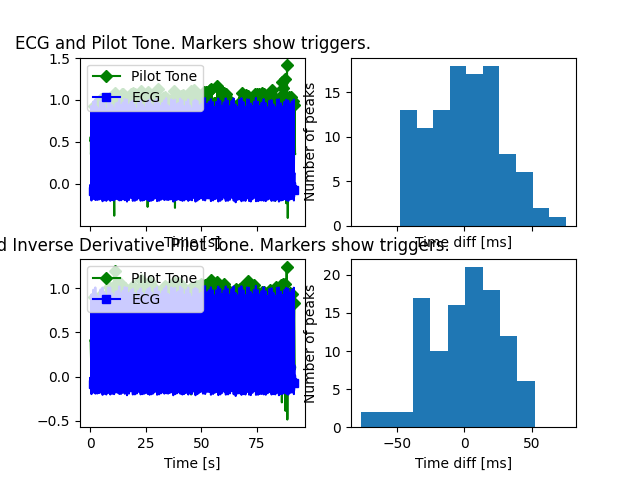

/tmp/ipykernel_2884389/3137943475.py:32: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


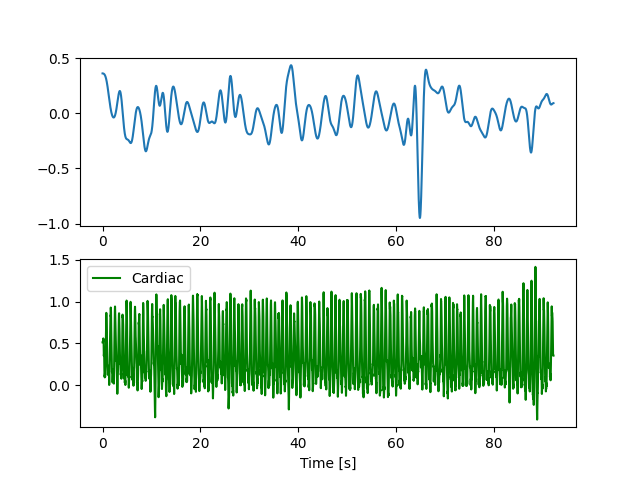

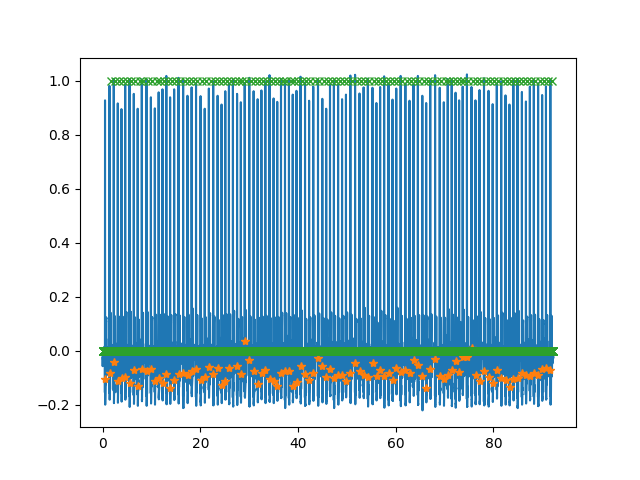

In [70]:

if cfg['saving']['save_pt_separate']:
    print('Saving waveforms separately...')
    np.savez(os.path.join(data_dir, f"{ismrmrd_data_fullpath.split('/')[-1][:-3]}_ptwaveforms.npz"), 
                pt_respiratory=pt_respiratory, 
                pt_cardiac=pt_cardiac,
                time_pt=time_pt)

pt_cardiac = cfg['pilottone']['cardiac']['sign']*pt_cardiac
pt_cardiac[:20] = pt_cardiac[20]
pt_cardiac[-20:] = pt_cardiac[-20]
pt_cardiac -= np.percentile(pt_cardiac, 10)
pt_cardiac /= np.percentile(pt_cardiac, 95)

pt_cardiac_filtered = savgol_filter(pt_cardiac, sg_filter_len, 3, axis=0)
pt_cardiac_derivative = np.hstack((0, np.diff(pt_cardiac_filtered)/(time_pt[1] - time_pt[0])))
pt_cardiac_derivative[:20] = pt_cardiac_derivative[20]
pt_cardiac_derivative[-20:] = pt_cardiac_derivative[-20]
pt_cardiac_derivative -= np.percentile(pt_cardiac_derivative, 10)
pt_cardiac_derivative /= np.percentile(pt_cardiac_derivative, 98)

pt_cardiac_trigs = extract_triggers(time_pt, pt_cardiac, skip_time=1, prominence=0.4, max_hr=160)
pt_derivative_trigs = extract_triggers(time_pt, pt_cardiac_derivative, skip_time=1, prominence=0.5, max_hr=160)

if ecg is not None:
    _,_ = pt_ecg_jitter(time_pt, pt_cardiac, pt_cardiac_derivative,
                        time_ecg, ecg_waveform, 
                        pt_cardiac_trigs=pt_cardiac_trigs, pt_derivative_trigs=pt_derivative_trigs, ecg_trigs=ecg_trigs, 
                        skip_time=1, show_outputs=cfg['pilottone']['show_outputs'])
    f, axs = plt.subplots(2,1)

    axs[0].plot(time_pt, pt_respiratory, label='Respiratory')
    plt.legend()
    axs[1].plot(time_pt, pt_cardiac, label='Cardiac', color='green')
    axs[1].set_xlabel('Time [s]')
    plt.legend()
    plt.show()
elif ecg is None and cfg['pilottone']['show_outputs']:
    fig, axs = plt.subplots(2,1, figsize=(10, 6), sharex=True)
    axs[0].plot(time_pt, pt_cardiac, label='Cardiac')
    axs[0].plot(time_pt, pt_cardiac_derivative, label='Cardiac Derivative')
    axs[0].plot(time_pt[pt_cardiac_trigs==1], pt_cardiac[pt_cardiac_trigs==1], '*', label='Cardiac Triggers')
    axs[0].plot(time_pt[pt_derivative_trigs==1], pt_cardiac_derivative[pt_derivative_trigs==1], '*', label='Cardiac Derivative Triggers')
    axs[0].set_title('Cardiac Triggers')
    axs[0].set_xlabel('Time [s]')
    axs[0].legend()
    axs[1].plot(time_pt, pt_respiratory, label='Respiratory')
    axs[1].set_title('Respiratory')
    axs[1].set_xlabel('Time [s]')
    axs[1].legend()
    plt.show()




 ## Save the waveforms into the original data

 Concat, and normalize pt waveforms.

 # Save the PT subtracted k-space

 Read the noise data in

 Update new parameters to XML header.

 Copy and fix acquisition objects

 Check if filepaths are provided as arguments

 Get filepaths if not provided